# Simple fiber coupling analysis using Zemax's POP

<img src="https://raw.githubusercontent.com/indranilsinharoy/PyZDDE/master/Doc/Images/articleBanner_02_fibercoupling.png" height="230">

*Please feel free to [e-mail](mailto:indranil_leo@yahoo.com) any corrections, comments and suggestions to the author ([Indranil Sinharoy](http://indranilsinharoy.com/))*  

Last updated: 12/27/2015

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0/)

**Reference**

The source of this material is from a Zemax webinar called [Understanding Single-Mode Fiber Coupling with Rays and Physical Optics](http://www.zemax.com/support/resource-center/webinars/understanding-single-mode-fiber-coupling-with-rays) hosted by Dr. Mark Nicholson on 1/29/2013. 

Please note that if there are any errors in concepts discussed here, it is mostly likely due to my lack of understanding and not made by Zemax, or the host of the above webniar. Also, please note that this article is a part of my own notes (as I learn Zemax), and it has not been sponsored by Zemax. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pyzdde.zdde as pyz
%matplotlib inline

In [2]:
ln = pyz.createLink()

Load the lens file "Fiber Coupling.zmx" that comes with Zemax as an example of POP computation.

In [3]:
zmxfile = 'Fiber Coupling.zmx'
lensPath = ln.zGetPath()[1]
lensFile = os.path.join(lensPath, 'Physical Optics', zmxfile)
ln.zLoadFile(lensFile)

0

In this example, we have a lens (see the LDE and the layout plot below) that has almost no aberrations, a Gaussian TEM00 beam that is propagating in free space starting from the ``STO`` surface to the lens, and then the beam is focused by the lens. The focused beam is the coupled into the receiving fiber at the right end.

In [4]:
ln.ipzGetLDE()

SURFACE DATA SUMMARY:

Surf     Type         Radius      Thickness                Glass      Diameter          Conic   Comment
 OBJ STANDARD       Infinity       Infinity                                  0              0
 STO STANDARD       Infinity              5                                  4              0
   2 STANDARD       Infinity             10                  N15            16              0
   3 STANDARD            -25             50                                 16          -2.25
 IMA STANDARD       Infinity                                                 2              0 FOCUS AT FIBER


There is just one wavelength defined for the system. The wavelength is 1 $\mu m$ as shown below

In [5]:
ln.zGetWaveTuple()

waveDataTuple(wavelengths=(1.0,), weights=(1.0,))

We can also see the fields set

In [6]:
ln.zGetFieldTuple()

(fieldData(xf=0.0, yf=0.0, wgt=1.0, vdx=0.0, vdy=0.0, vcx=0.0, vcy=0.0, van=0.0),)

The lens is truely diffraction limited, as shown by the Seidel aberration coefficients.

In [7]:
ln.zGetSeidelAberration()

{u'W020': 0.0,
 u'W040': -0.0,
 u'W111': 0.0,
 u'W131': 0.0,
 u'W220M': 0.0,
 u'W220P': 0.0,
 u'W220S': 0.0,
 u'W220T': 0.0,
 u'W222': 0.0,
 u'W311': 0.0}

##### Layout plot

The layout plot shows where we will place the input Gaussian beam (at the location of STO). The beam, after passing through the lens should be focused into the fiber. The surface numbers for the stop and fiber are shown in parentheses.

In [8]:
ln.zPushLens(1) # was pushed to LDE, and made sure that the "Frame suppress" was check on layout plot

0

In [9]:
lay = ln.ipzCaptureWindow('Lay', percent=15, gamma=0.1, retArr=True)

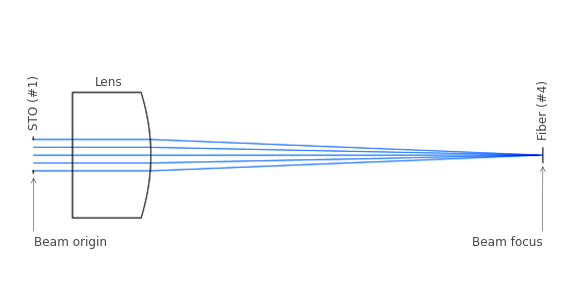

In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# Render the array
pyz.imshow(lay, cropBorderPixels=(2, 5, 60, 90), fig=fig, faxes=ax)
ax.text(85, 75, "Lens", fontsize=12)
ax.text(20, 75, "STO (#1)", fontsize=12, rotation='vertical')
ax.text(510, 80, "Fiber (#4)", fontsize=12, rotation='vertical')
col = (0.08,0.08,0.08)
ax.annotate("{}".format('Beam origin'), (25, 163), (25, 230), fontsize=12, 
                arrowprops=dict(arrowstyle="->", linewidth=0.45, color=col, 
                                relpos=(0.0,0.5)))
ax.annotate("{}".format('Beam focus'), (516, 152), (448, 230), fontsize=12, 
                arrowprops=dict(arrowstyle="->", linewidth=0.45, color=col, 
                                relpos=(1.0,0.5)))
#ax.set_title('Layout plot', fontsize=14)
plt.show()

We will now set up the POP analysis and see the irradiance and phase distribution of the input beam at surfaces 1 and 4, using the function ``zSetPOPSettings()``. Please refer to the function's docstring for details on the function.

The input beam is defined as follows:

```
Beam type : Gaussian waist
Mode  : TEM00
Waist : 2 mm 
Total power : 1 Watt
```

The beam waist of the input beam is located at the ``STO`` surface (surface to beam = 0).

The receiver fiber settings are as follows:

```
Beam type : Gaussian waist
Mode : TEM00
Waist : 8 microns (0.008 mm)
```

The modal radius that the receiving fiber supports is an 8 microns beam waist.

In [11]:
sfile = ln.zSetPOPSettings(data=0, startSurf=1, endSurf=1, field=1, wave=1, 
                           beamType=0, paramN=((1, 2), (2, 2)), tPow=1, 
                           sampx=4, sampy=4, widex=40, widey=40)

The above function creates .cfg file (if not provided with one) after setting the appropriate parameters for the POP analysis and returns the full name of the file.

Note that we want to analyze the effect of the beam that is propagating from surace 1 to surface 4. However, in the above function we set the `endSurf` to 1 in order to retrieve the POP data at the ``STO``  surface. Also, in the above function call, we did not select the "compute fiber coupling integral" option. This is because we are interested in the fiber coupling computation at the surface 4.

##### Irradiance data at ``STO`` surface:

In [12]:
irr_sur1, irrGridDat_sur1 = ln.zGetPOP(settingsFile=sfile, displayData=True)

The function returns to data structures --- ``irr_sur1`` contains POP analysis data such as peak irradiance, total power, rayleigh, etc, and ``irrGridDat_sur1`` contains the 2D irradiance plot data. We will plot this data later along with the irradiance and phase data of surface 4 (at the coupling).

In [13]:
irr_sur1

POPinfo(surf=1, peakIrr=0.15915, totPow=1.0, fibEffSys=None, fibEffRec=None, coupling=None, pilotSize=2.0, pilotWaist=2.0, pos=0.0, rayleigh=12566.4, gridX=256, gridY=256, widthX=40.0, widthY=40.0)

##### Irradiance data at surface 4:

To get the beam parameters at the surface 4, we will need to modify the ``endSurf`` to 4. Also, since we are interested in fiber coupling integral computation at this surface, we will specify the fiber type and other fiber parameters as shown below. 

In [14]:
ln.zModifyPOPSettings(settingsFile=sfile, endSurf=4, fibComp=1, 
                      fibType=0, fparamN=((1, 2), (0.008, 0.008)))

(0, 0, 0, (0, 0))

The tuple of zeros in the above indicate that all the settings were successfully modified.

In [15]:
irr_sur4, irrGridDat_sur4 = ln.zGetPOP(settingsFile=sfile, displayData=True)

In [16]:
irr_sur4

POPinfo(surf=4, peakIrr=10078.0, totPow=1.0, fibEffSys=1.0, fibEffRec=0.999955, coupling=0.999955, pilotSize=0.0079605, pilotWaist=0.0079605, pos=0.00060786, rayleigh=0.19908, gridX=256, gridY=256, widthX=0.3201024, widthY=0.3201024)

From the above we see that the **system efficiency**, which is the energy transported by the optical system is 1. The **receiver efficiency** is 0.999955, and the **coupling efficiency** is 0.999955.

##### Phase data at ``STO`` surface:

In order to get the phase information we need to use the function ``zSetPOPSettings()`` once again. This is mainly because there is (currently) no way to modify the "Data" parameter externally. So in PyZDDE, we create a new settings file when everytime we switch between "Phase" and "Irradiance" data. Since we have already retrieved the irradiance data, we will re-use the name of the previous settings file. 

In [17]:
sfile = ln.zSetPOPSettings(data=1, startSurf=1, endSurf=1, field=1, 
                           wave=1, beamType=0, paramN=((1, 2), (2, 2)), 
                           tPow=1, sampx=4,sampy=4, widex=40, widey=40)

In [18]:
pha_sur1, phaGridDat_sur1 = ln.zGetPOP(settingsFile=sfile, displayData=True)

In [19]:
pha_sur1

POPinfo(surf=1, cenPhase=0.0, blank=None, fibEffSys=None, fibEffRec=None, coupling=None, pilotSize=2.0, pilotWaist=2.0, pos=0.0, rayleigh=12566.4, gridX=256, gridY=256, widthX=40.0, widthY=40.0)

##### Phase data at surface 4:

In [20]:
ln.zModifyPOPSettings(settingsFile=sfile, endSurf=4, fibComp=1, fibType=0,
                      fparamN=((1, 2), (0.008, 0.008))) # Change analysis surface to 4 and add fiber comp

(0, 0, 0, (0, 0))

In [21]:
pha_sur4, phaGridDat_sur4 = ln.zGetPOP(settingsFile=sfile, displayData=True)

##### Plot of the irradiance and phase data at the two surfaces

In the following sections we shall use matplotlib to render the raw data which we have grabbed above. Consequently, will will have to write code for generating the plots. The advantage is that we have complete control of how we want to analyze and present the data. For quick notes, you can always use ``zCaptureWindow()`` to grab the POP graphic window from Zemax as shown in an example at the end of this article.

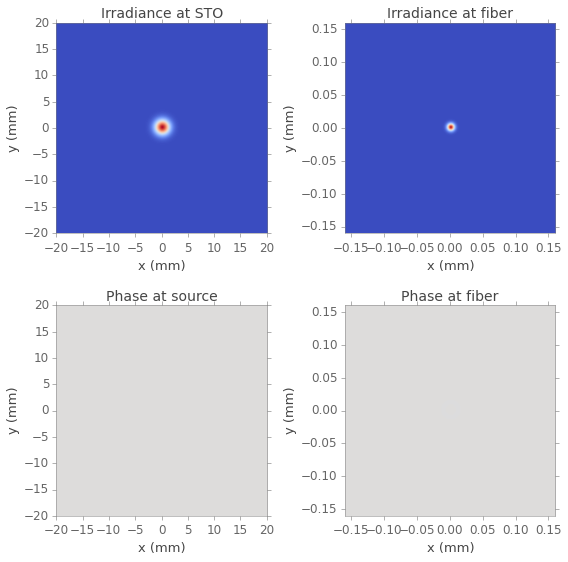

In [22]:
fig = plt.figure(figsize=(8,8))

# irradiance data
ax = fig.add_subplot(2,2,1)
ax.set_title('Irradiance at STO', fontsize=14)
irrmax = np.max(irrGridDat_sur1)
ext = [-irr_sur1.widthX/2, irr_sur1.widthX/2,
       -irr_sur1.widthY/2, irr_sur1.widthY/2]
ax.imshow(irrGridDat_sur1, extent=ext, origin='lower', 
          cmap=plt.cm.coolwarm, vmin=0, vmax=irrmax)
ax.set_xlabel('x (mm)', fontsize=13)
ax.set_ylabel('y (mm)', fontsize=13)

ax = fig.add_subplot(2,2,2)
ax.set_title('Irradiance at fiber', fontsize=14)
irrmax = np.max(irrGridDat_sur4)
ext = [-irr_sur4.widthX/2, irr_sur4.widthX/2,
       -irr_sur4.widthY/2, irr_sur4.widthY/2]
ax.imshow(irrGridDat_sur4, extent=ext, origin='lower', 
          cmap=plt.cm.coolwarm, vmin=0, vmax=irrmax)
ax.set_xlabel('x (mm)', fontsize=13) 
ax.set_ylabel('y (mm)', fontsize=13)

# phase data
ax = fig.add_subplot(2,2,3)
ax.set_title('Phase at source', fontsize=14)
ext = [-pha_sur1.widthX/2, pha_sur1.widthX/2,
       -pha_sur1.widthY/2, pha_sur1.widthY/2]
ax.imshow(phaGridDat_sur1, extent=ext, origin='lower',
          vmin=-np.pi, vmax=np.pi,  cmap=plt.cm.coolwarm)
ax.set_xlabel('x (mm)', fontsize=13) 
ax.set_ylabel('y (mm)', fontsize=13)

ax = fig.add_subplot(2,2,4)
ax.set_title('Phase at fiber', fontsize=14)
ext = [-pha_sur4.widthX/2, pha_sur4.widthX/2,
       -pha_sur4.widthY/2, pha_sur4.widthY/2]
ax.imshow(phaGridDat_sur4, extent=ext, origin='lower', 
          vmin=-np.pi, vmax=np.pi,  cmap=plt.cm.coolwarm)
ax.set_xlabel('x (mm)', fontsize=13)
ax.set_ylabel('y (mm)', fontsize=13)

fig.tight_layout()
plt.show()

From the above plots we can see that there is no <u>appreciable</u> change in the phase of the beam. In order to get a better picture, we will plot slices of the 2D data.

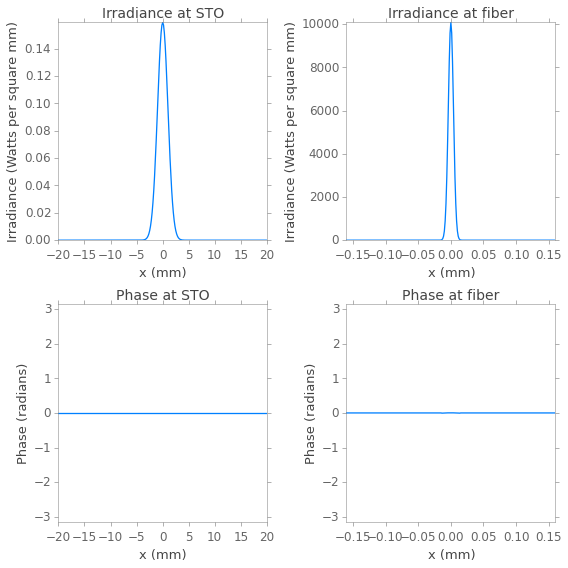

In [23]:
fig = plt.figure(figsize=(8,8))

# irradiance data
ax = fig.add_subplot(2,2,1)
ax.set_title('Irradiance at STO', fontsize=14)
dx = irr_sur1[-2]/256
x = [-irr_sur1[-2]/2 + dx*i for i in range(256)]
ax.plot(x, irrGridDat_sur1[128])
ax.set_ylim(top=np.max(np.array(irrGridDat_sur1[128])))
ax.set_xlim(left=-irr_sur1[-2]/2, right=irr_sur1[-2]/2)
ax.set_xlabel('x (mm)', fontsize=13)
ax.set_ylabel('Irradiance (Watts per square mm)', fontsize=13)

ax = fig.add_subplot(2,2,2)
dx = irr_sur4[-2]/256
x = [-irr_sur4[-2]/2 + dx*i for i in range(256)]
ax.set_title('Irradiance at fiber', fontsize=14)
ax.plot(x, irrGridDat_sur4[128])
ax.set_ylim(top=np.max(np.array(irrGridDat_sur4[128])))
ax.set_xlim(left=-irr_sur4[-2]/2, right=irr_sur4[-2]/2)
ax.set_xlabel('x (mm)', fontsize=13) 
ax.set_ylabel('Irradiance (Watts per square mm)', fontsize=13)

# phase data
ax = fig.add_subplot(2,2,3)
ax.set_title('Phase at STO', fontsize=14)
dx = pha_sur1[-2]/256
x = [-pha_sur1[-2]/2 + dx*i for i in range(256)]
ax.plot(x, phaGridDat_sur1[128])
ax.set_ylim(top=np.pi, bottom=-np.pi)
ax.set_xlim(left=-pha_sur1[-2]/2, right=pha_sur1[-2]/2)
ax.set_xlabel('x (mm)', fontsize=13) 
ax.set_ylabel('Phase (radians)', fontsize=13)

ax = fig.add_subplot(2,2,4)
ax.set_title('Phase at fiber', fontsize=14)
dx = pha_sur4[-2]/256
x = [-pha_sur4[-2]/2 + dx*i for i in range(256)]
ax.plot(x, phaGridDat_sur4[128])
ax.set_ylim(top=np.pi, bottom=-np.pi)
ax.set_xlim(left=-pha_sur4[-2]/2, right=pha_sur4[-2]/2)
ax.set_xlabel('x (mm)', fontsize=13)
ax.set_ylabel('Phase (radians)', fontsize=13)

fig.tight_layout()
plt.show()

We can zoom-in into to the irradiance slice plot at the fiber and see that the fiber is "perfectly coupled" as the beam size (radius) defined by $1/e^2$ width at the point of focus is very close to 8 microns (indicated by the red dashed vertical lines), which is the modal radius of the fiber we have defined.

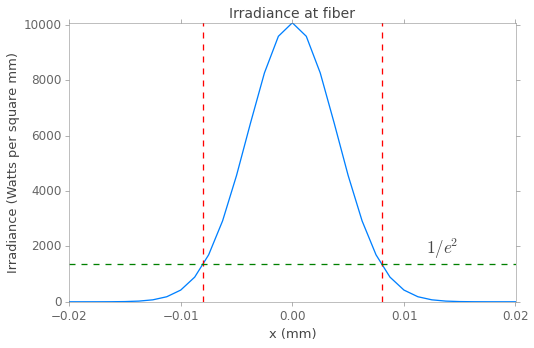

In [24]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
dx = irr_sur4[-2]/256
x = [-irr_sur4[-2]/2 + dx*i for i in range(256)]
ax.set_title('Irradiance at fiber', fontsize=14)
ax.plot(x, irrGridDat_sur4[128])
ymax = np.max(np.array(irrGridDat_sur4[128]))
xlim = irr_sur4[-2]/16
ax.set_ylim(top=ymax)
ax.set_xlim(left=-xlim, right=xlim)
ax.axvline(x=-0.008, ymax=ymax, color='r', ls='--')
ax.axvline(x=0.008, ymax=ymax, color='r', ls='--')
ax.axhline(y=ymax/np.e**2, color='g', ls='--')
ax.text(0.012, 1730, r'$1/e^2$', fontsize=17)
ax.set_xlabel('x (mm)', fontsize=13) 
ax.set_ylabel('Irradiance (Watts per square mm)', fontsize=13)
plt.show()

Now, if we change the input beam waist to be 1.5 mm instead of 2 mm, which was the perfect coupling case, we will see that the coupling efficiency will decrease.

In [25]:
sfile = ln.zSetPOPSettings(data=0, startSurf=1, endSurf=4, field=1, 
                           wave=1, beamType=0, paramN=((1, 2), (1.5, 1.5)), 
                           tPow=1, sampx=4, sampy=4, widex=40, widey=40,
                           fibComp=1, fibType=0, fparamN=((1, 2), (0.008, 0.008)))

In [26]:
irr_sur4_imperfect, irrGridDat_sur4_imperfect = ln.zGetPOP(settingsFile=sfile, displayData=True)

In [27]:
irr_sur4_imperfect

POPinfo(surf=4, peakIrr=5661.0, totPow=1.0, fibEffSys=1.0, fibEffRec=0.924587, coupling=0.924587, pilotSize=0.010614, pilotWaist=0.010614, pos=0.0019214, rayleigh=0.35392, gridX=256, gridY=256, widthX=0.3201024, widthY=0.3201024)

We can see that the coupling efficiency decreased to 0.924587 We can also see that the $1/e^2$ beam size at the point of coupling with the fiber is greater than 8 microns (indicated by the red dashed vertical lines) resulting in a loss of energy.

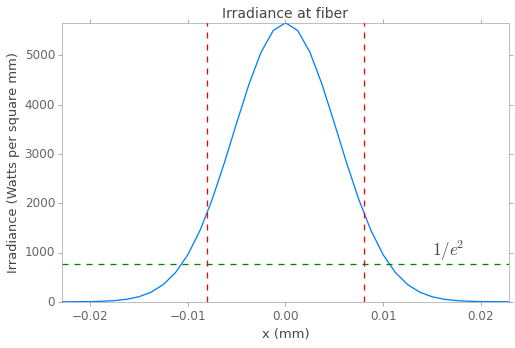

In [28]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
dx = irr_sur4_imperfect[-2]/256
x = [-irr_sur4_imperfect[-2]/2 + dx*i for i in range(256)]
ax.set_title('Irradiance at fiber', fontsize=14)
ax.plot(x, irrGridDat_sur4_imperfect[128])
ymax = np.max(np.array(irrGridDat_sur4_imperfect[128]))
xlim = irr_sur4[-2]/14
ax.set_ylim(top=ymax)
ax.set_xlim(left=-xlim, right=xlim)
ax.axvline(x=-0.008, ymax=ymax, color='r', ls='--')
ax.axvline(x=0.008, ymax=ymax, color='r', ls='--')
ax.axhline(y=ymax/np.e**2, color='g', ls='--')
ax.text(0.015, 930, r'$1/e^2$', fontsize=17)
ax.set_xlabel('x (mm)', fontsize=13) 
ax.set_ylabel('Irradiance (Watts per square mm)', fontsize=13)
plt.show()

### Effect of moving the beam origin to the left

We will now see the effect of changing the origin of the beam behind the stop by 3000 *mm*. In Zemax, under POP analysis, there is an option called "Surface to Beam" that specifies the distance from the starting surface to the beam position in lens units. 

Unfortunately, we cannot modify this POP parameter through the DDE. One way of achieving the same objective is to create a dummy surface of thickness 3000 *mm* between the ``OBJ`` and ``STO`` and specify this surface as the start position of the beam. 

In [29]:
ln.zInsertSurface(1)

0

In [30]:
ln.zSetSurfaceData(surfNum=1, code=ln.SDAT_COMMENT, value='dummy')
ln.zSetSurfaceData(surfNum=1, code=ln.SDAT_THICK, value=3000)

3000.0

In [31]:
ln.ipzGetLDE()

SURFACE DATA SUMMARY:

Surf     Type         Radius      Thickness                Glass      Diameter          Conic   Comment
 OBJ STANDARD       Infinity       Infinity                                  0              0
   1 STANDARD       Infinity           3000                                  4              0 dummy
 STO STANDARD       Infinity              5                                  4              0
   3 STANDARD       Infinity             10                  N15            16              0
   4 STANDARD            -25             50                                 16          -2.25
 IMA STANDARD       Infinity                                                 2              0 FOCUS AT FIBER


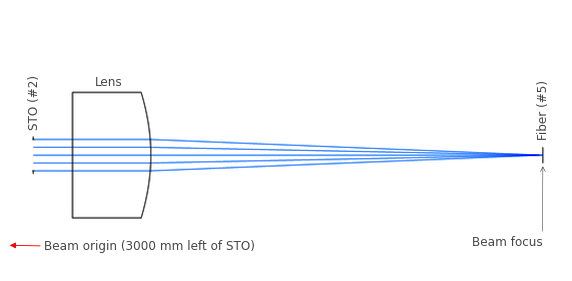

In [32]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

# Render the array
pyz.imshow(lay, cropBorderPixels=(2, 5, 60, 90), fig=fig, faxes=ax)
ax.text(85, 75, "Lens", fontsize=12)
ax.text(20, 75, "STO (#2)", fontsize=12, rotation='vertical')
ax.text(510, 80, "Fiber (#5)", fontsize=12, rotation='vertical')
col = (0.08,0.08,0.08)
ax.annotate("{}".format('Beam origin (3000 mm left of STO)'), (0, 230), (35, 234), fontsize=12, 
                arrowprops=dict(arrowstyle="-|>", linewidth=0.9, color='r', 
                                relpos=(0.0,0.5)))
ax.annotate("{}".format('Beam focus'), (516, 152), (448, 230), fontsize=12, 
                arrowprops=dict(arrowstyle="->", linewidth=0.45, color=col, 
                                relpos=(1.0,0.5)))
#ax.set_title('Layout plot', fontsize=14)
plt.show()

##### Intensity at surface ``STO``

Note that the surface numbers have changed. We will create a new settings file by not passing a settings file-name to ``zSetPOPSettings()``. (Also, since it will have the same name, the old file will be overwritten.)

In [33]:
sfile = ln.zSetPOPSettings(startSurf=1, endSurf=2, field=1, wave=1, 
                           beamType=0, paramN=((1, 2), (2, 2)), tPow=1, 
                           sampx=4, sampy=4, widex=40, widey=40)

In [34]:
new_irr_sur2, new_irrGridDat_sur2 = ln.zGetPOP(settingsFile=sfile, displayData=True)

##### Intensity at Fiber

In [35]:
ln.zModifyPOPSettings(settingsFile=sfile, endSurf=5, fibComp=1, 
                      fibType=0, fparamN=((1, 2), (0.008, 0.008)))

(0, 0, 0, (0, 0))

In [36]:
new_irr_sur5, new_irrGridDat_sur5 = ln.zGetPOP(settingsFile=sfile, displayData=True)                       

##### Phase at surface ``STO``

In [37]:
sfile = ln.zSetPOPSettings(data= 1, startSurf=1, endSurf=2, field=1, wave=1, 
                           beamType=0, paramN=((1, 2), (2, 2)), tPow=1, 
                           sampx=4, sampy=4, widex=40, widey=40)

In [38]:
new_pha_sur2, new_phaGridDat_sur2 = ln.zGetPOP(settingsFile=sfile, displayData=True)

##### Phase at Fiber

In [39]:
ln.zModifyPOPSettings(settingsFile=sfile, endSurf=5, fibComp=1, 
                      fibType=0, fparamN=((1, 2), (0.008, 0.008)))

(0, 0, 0, (0, 0))

In [40]:
new_pha_sur5, new_phaGridDat_sur5 = ln.zGetPOP(settingsFile=sfile, displayData=True)

##### Plots of irradiance and phase

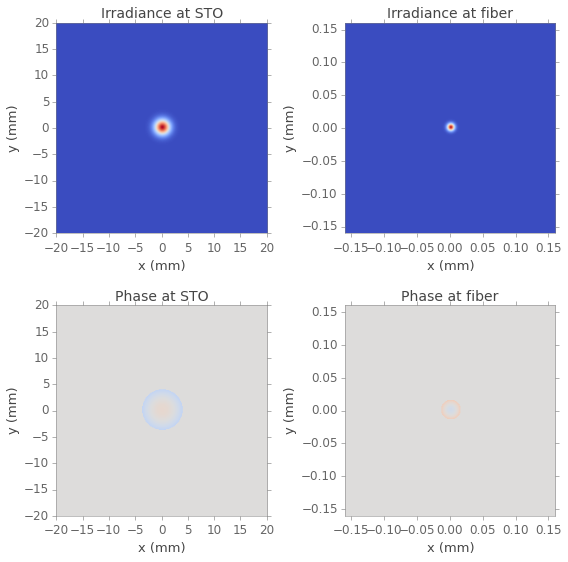

In [41]:
fig = plt.figure(figsize=(8,8))

# irradiance data
ax = fig.add_subplot(2,2,1)
ax.set_title('Irradiance at STO', fontsize=14)
ext = [-new_irr_sur2[-2]/2, new_irr_sur2[-2]/2,
       -new_irr_sur2[-1]/2, new_irr_sur2[-1]/2]
ax.imshow(new_irrGridDat_sur2, extent=ext, origin='lower', 
          cmap=plt.cm.coolwarm)
ax.set_xlabel('x (mm)', fontsize=13)
ax.set_ylabel('y (mm)', fontsize=13)

ax = fig.add_subplot(2,2,2)
ax.set_title('Irradiance at fiber', fontsize=14)
ext = [-new_irr_sur5[-2]/2, new_irr_sur5[-2]/2,
       -new_irr_sur5[-1]/2, new_irr_sur5[-1]/2]
ax.imshow(new_irrGridDat_sur5, extent=ext, origin='lower',
          cmap=plt.cm.coolwarm)
ax.set_xlabel('x (mm)', fontsize=13) 
ax.set_ylabel('y (mm)', fontsize=13)

# phase data
ax = fig.add_subplot(2,2,3)
ax.set_title('Phase at STO', fontsize=14)
ext = [-new_pha_sur2[-2]/2, new_pha_sur2[-2]/2,
       -new_pha_sur2[-1]/2, new_pha_sur2[-1]/2]
ax.imshow(new_phaGridDat_sur2, extent=ext, origin='lower',
          vmin=-np.pi, vmax=np.pi, cmap=plt.cm.coolwarm)
ax.set_xlabel('x (mm)', fontsize=13) 
ax.set_ylabel('y (mm)', fontsize=13)

ax = fig.add_subplot(2,2,4)
ax.set_title('Phase at fiber', fontsize=14)
ext = [-new_pha_sur5[-2]/2, new_pha_sur5[-2]/2,
       -new_pha_sur5[-1]/2, new_pha_sur5[-1]/2]
ax.imshow(new_phaGridDat_sur5, extent=ext, origin='lower', 
          vmin=-np.pi, vmax=np.pi,  cmap=plt.cm.coolwarm)
ax.set_xlabel('x (mm)', fontsize=13)
ax.set_ylabel('y (mm)', fontsize=13)
fig.tight_layout()
plt.show()

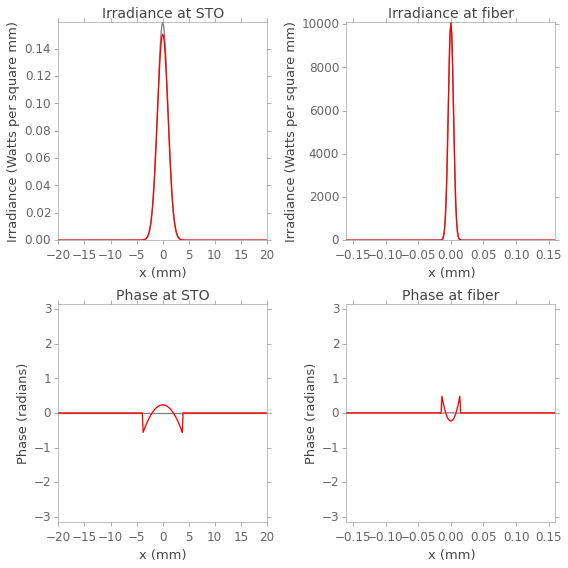

In [42]:
fig = plt.figure(figsize=(8,8))

# irradiance data
ax = fig.add_subplot(2,2,1)
ax.set_title('Irradiance at STO', fontsize=14)
dx = irr_sur1[-2]/256
x = [-irr_sur1[-2]/2 + dx*i for i in range(256)]
ax.plot(x, irrGridDat_sur1[128],'gray')
ax.plot(x, new_irrGridDat_sur2[128], 'r')
ax.set_ylim(top=np.max(np.array(irrGridDat_sur1[128])))
ax.set_xlim(left=-irr_sur1[-2]/2, right=irr_sur1[-2]/2)
ax.set_xlabel('x (mm)', fontsize=13)
ax.set_ylabel('Irradiance (Watts per square mm)', fontsize=13)

ax = fig.add_subplot(2,2,2)
dx = irr_sur4[-2]/256
x = [-irr_sur4[-2]/2 + dx*i for i in range(256)]
ax.set_title('Irradiance at fiber', fontsize=14)
ax.plot(x, irrGridDat_sur4[128],'gray')
ax.plot(x, new_irrGridDat_sur5[128], 'r')
ax.set_ylim(top=np.max(np.array(irrGridDat_sur4[128])))
ax.set_xlim(left=-irr_sur4[-2]/2, right=irr_sur4[-2]/2)
ax.set_xlabel('x (mm)', fontsize=13) 
ax.set_ylabel('Irradiance (Watts per square mm)', fontsize=13)

# phase data
ax = fig.add_subplot(2,2,3)
ax.set_title('Phase at STO', fontsize=14)
dx = pha_sur1[-2]/256
x = [-pha_sur1[-2]/2 + dx*i for i in range(256)]
ax.plot(x, phaGridDat_sur1[128],'gray')
ax.plot(x, new_phaGridDat_sur2[128], 'r')
ax.set_ylim(top=np.pi, bottom=-np.pi)
ax.set_xlim(left=-pha_sur1[-2]/2, right=pha_sur1[-2]/2)
ax.set_xlabel('x (mm)', fontsize=13) 
ax.set_ylabel('Phase (radians)', fontsize=13)
ax = fig.add_subplot(2,2,4)
ax.set_title('Phase at fiber', fontsize=14)
dx = pha_sur4[-2]/256
x = [-pha_sur4[-2]/2 + dx*i for i in range(256)]
ax.plot(x, phaGridDat_sur4[128],'gray')
ax.plot(x, new_phaGridDat_sur5[128], 'r')
ax.set_ylim(top=np.pi, bottom=-np.pi)
ax.set_xlim(left=-pha_sur4[-2]/2, right=pha_sur4[-2]/2)
ax.set_xlabel('x (mm)', fontsize=13)
ax.set_ylabel('Phase (radians)', fontsize=13)
fig.tight_layout()
plt.show()

In the above plots, the gray lines represent the intensity and phase data slices when the beam originated at the ``STO`` surface (i.e. surface to beam = 0). The red lines represent the intensity and phase data slices when the beam originated 3000 *mm* to the left of the ``STO`` surface. 

While the intensity plots for the two surfaces in both the cases are very similar, the phase plots show significant differences. Firstly, as the beam propagates from its waist position, 3000 mm behind the ``STO`` surface, to the ``STO`` surface its radius of curvature decreases from infinity to a finite value. Secondly, we can see the **Gouy shift** of phase profile of the Gaussian beam.

##### Coupling efficiency

In [43]:
new_irr_sur5

POPinfo(surf=5, peakIrr=10058.0, totPow=1.0, fibEffSys=1.0, fibEffRec=0.985784, coupling=0.985784, pilotSize=0.0079602, pilotWaist=0.0077483, pos=-0.044419, rayleigh=0.18861, gridX=256, gridY=256, widthX=0.320384, widthY=0.320384)

The coupling efficiency reduced from 0.999955 to 0.985784.

The coupling efficiency decreases because the fiber's mode which we have defined as having a flat phase profile doesn't match that of the input (to the fiber) beam.

#### Grabbing POP window from Zemax 

I used matplotlib to create the above plots using the raw data extracted from Zemax. However, it is entirely possible to grab the Zemax plots as shown with the following example.

In [44]:
pyz.findZButtonCode('physical optics') # What is the button code?

[Pop] Physical Optics Propagation

Found 1 Button codes

In [47]:
sfile = ln.zSetPOPSettings(startSurf=1, endSurf=2, field=1, wave=1, 
                           beamType=0, paramN=((1, 2), (2, 2)), tPow=1, 
                           sampx=4, sampy=4, widex=40, widey=40)

In [49]:
sfile

'C:\\Users\\Indranil\\Documents\\ZEMAX\\SAMPLES\\Physical Optics\\Fiber Coupling_pyzdde_POP.CFG'

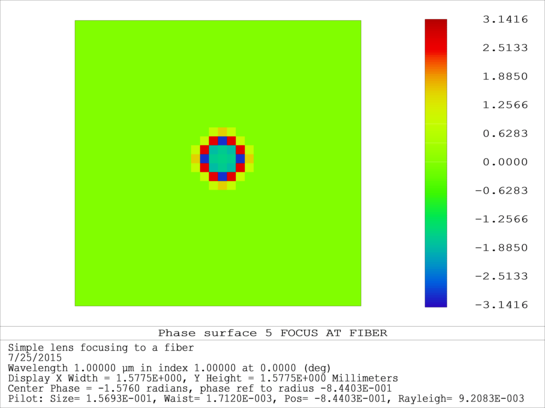

In [48]:
ln.ipzCaptureWindow('Pop', percent=15, gamma=0.9)

In [50]:
ln.close()